#Problème: Cible fragmentaire et fusion de donnée





In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import os
#############################################################
#pour la visualisation des images ###########################
#############################################################

def voir_mat(data2, fig, min_scale=-10,max_scale=70):

    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(data2, interpolation='nearest', cmap=plt.cm.rainbow) #cmap=plt.cm.ocean)
    plt.clim(min_scale,max_scale)
    plt.colorbar()
    plt.show()

def voir_tens(image, fig, min_scale=-1,max_scale=1):
    im=image[0,0,:,:].numpy()
    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(im, interpolation='nearest',  cmap=plt.cm.rainbow) #cmap=plt.cm.ocean)
    plt.clim(min_scale,max_scale)
    plt.colorbar()
    plt.show()

def conc(image1,image2,dim=3):
    return torch.cat((image1,image2), dim) #, out=None)

def multi_conc(L,dim=1,ecart=5, min_scale=0.5):
    image1=L[0]
    for i in range(1, len(L)):
        if dim==1:
            sep=  min_scale + 0*image1[:,0:ecart]
        elif dim==0:
            sep=  min_scale + 0*image1[0:ecart,:]
        image1=conc(image1,sep,dim)
        image2=L[i]
        image1=conc(image1,image2,dim=dim)
    return image1

def images_from_tenseur(tens, k=0):
    len_batch=tens.shape[0]
    L=[]
    for i in range(len_batch):
        L.append(tens[i,k,:,:])
    return L

def voir_batch2D(tens, nx, fig,k=0, min_scale=-10,max_scale=1):
    s = 0.5*(min_scale + max_scale)
    L=images_from_tenseur(tens,k)
    image1=multi_conc(L[0:nx],dim=1, min_scale=s)
    for i in range(1,int(len(L)/nx)):
        image2=multi_conc(L[i*nx:(i+1)*nx],dim=1, min_scale=s)
        image1=multi_conc([image1,image2],dim=0, min_scale=s)
    voir_mat(image1, fig, min_scale,max_scale)


#############################################################
#pour la génération des images    ###########################
#############################################################

def simu_rec(image, L,l,  fields=0):
    channels,size,size2=image.size()
    rec= torch.zeros(channels,size,size2)
    #out = 0*(image.clone())
    vertical=np.random.binomial(1,0.5)==1
    if vertical:
        width=l
        height=L
    else:
        width=L
        height=l

    top=randint(0, size-height)
    left=randint(0, size-width)
    rec[fields,top:top+height,left:left+width]=  np.random.uniform(0,0.4)   #0.1
    image=image + rec
    return image

def simu_noisy_rec(image, L,l,  fields=0):
    channels,size,size2=image.size()
    rec= torch.zeros(channels,size,size2)
    #out = 0*(image.clone())
    vertical=np.random.binomial(1,0.5)==1
    if vertical:
        width=l
        height=L
    else:
        width=L
        height=l

    top=randint(0, size-height)
    left=randint(0, size-width)
    rec[fields,top:top+height,left:left+width]= np.random.uniform(0,0.4)  #0.1
    noise=torch.randn(channels,size,size2)
    noise=noise*(noise>0).float()
    rec=noise*rec
    image=image + rec
    return image

def simu_disc(image, f, radius=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius, size-radius) , randint(radius, size-radius) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc=np.random.uniform(0.6,1.) * npdisc  #variation on intensity
    image[fields,:,:] = image[fields,:,:] + torch.from_numpy(npdisc).float()   #matrice des distances < rayon
    return image

def simu_disc_with_cond(image, f, radius=15, fields=0, f2 = lambda a,x  : ((np.sin(3.1 * a/x**2)))*(a < x**2) ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius-5, size-radius+2) , randint(radius-2, size-radius+5) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc=np.random.uniform(0.6,1.) * npdisc  #variation on intensity
    image[0,:,:] = image[0,:,:] + torch.from_numpy(npdisc).float()   #matrice des distances < rayon
    if (radius >= 10) and (radius <= 14):
        npdon = f2( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
        image[1,:,:] = image[1,:,:] + torch.from_numpy(npdon).float()**2
    return image


def simu_square(image, f, diag=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2 = image.size()
    center=np.array([randint(diag, size-diag) , randint(diag, size-diag) ])

    npsquare = f(  np.abs(np.arange(0,64)*np.ones([size,size]) - center[0]) + \
                   np.abs(np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1]), diag)
#    npsquare = np.abs(np.arange(0,64)*np.ones([size,size]) - center[0])
    npsquare = np.random.uniform(0.6,1.) * npsquare  #variation on intensity
    image[fields,:,:] = image[fields,:,:] + torch.from_numpy(npsquare).float()   #matrice des distances < rayon
    return image


def plot_pairs(image, f = lambda x : x**2):
    horizontal = (torch.randint(0,2,(1,)) > 0.5).item()
#    print(horizontal)
    dist = torch.randint(1,32, (1,)).item()
    if horizontal :
        ordo = torch.randint(0, 64, (1,)).item()
        absi = torch.randint(0, 64 - dist, (1,)).item()
        image[1, ordo, absi:(absi + dist + 1)] \
            += 0.1 + torch.mean(f(image[0, ordo, absi:(absi + dist + 1)]))
    else :
        ordo = torch.randint(0, 64 - dist, (1,)).item()
        absi = torch.randint(0, 64, (1,)).item()
        image[1, ordo:ordo+dist+1, absi] \
            += 0.1 + torch.mean(f(image[0, ordo:ordo+dist+1, absi]))
    return image


def generate_noise(image, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,10)
        image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image= simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    if pola[0]==1:      #add a pseudo pola field
        image_pola = generate_pola(image,pola)
        image=torch.cat([image,image_pola],dim=0)
    return image


def generate_noise_with_cond(image, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(6,18)
        image=simu_disc_with_cond(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image= simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    return image


def generate_noise_and_pairs(image, lambda_pairs = 0.01, lambda_rec=0.001 ,lambda_noisy_rec = 0.001, lambda_disc = 0.001, lambda_square = 0., pola=[0,0.5,0.1]):
    for k in range(np.random.poisson(lambda_disc*64*64)):
        r = randint(5,10)
        image=simu_disc(image, lambda a,x  : (0.39 - 0.36*a/x**2)*(a < x**2) ,radius = r)  #0.47 pour avoir 40 dB
    for k in range(np.random.poisson(lambda_square*64*64)):
        r = randint(5,10)
        image=simu_square(image, lambda a,x  : (0.5 - 0.45*a/x)*(a < x) , diag = r)  #0.47 pour avoir 40 dB
#        print(r)

    for i in range(np.random.poisson(lambda_rec*64*64)):
        L=randint(20,50)
        l=randint(2,10)
        image= simu_rec(image,L,l)
    for j in range(np.random.poisson(lambda_noisy_rec*64*64)):
        L=randint(10,30)
        l=randint(10,30)
        image = simu_noisy_rec(image,L,l)
        # 0.3*np.exp(-0.1 * a/x)*(a < x**2)  #image=simu_disque(image, lambda a,x  : 1.0*(a < x**2)  )
    # on ajoute le deuxième canal où les échanges entre signaux seront
    # représentés

    image2 = torch.zeros([1,64, 64])
    image = torch.cat([image,image2], dim = 0 )

    for j in range(np.random.poisson(lambda_pairs*64*64)):
        image = plot_pairs(image)

    return image


def make_image(rec, noisy_rec ,disc,square=0., pola=[0]):
    image=torch.zeros([1,64, 64])
    image = generate_noise(image, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_image_with_cond(rec, noisy_rec ,disc,square=0., pola=[0]):
    image = torch.zeros([2, 64, 64])
    image = generate_noise_with_cond(image, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_batch(batch_size, rec, noisy_rec ,disc, square=0., pola=[0] ):
    out = make_image(rec, noisy_rec ,disc , square, pola ).unsqueeze(0)
    for i in range(batch_size-1):
        new=make_image(rec, noisy_rec ,disc, square, pola).unsqueeze(0)
        out=torch.cat((out,new), dim=0)
    return out

def make_batch_with_cond(batch_size, rec, noisy_rec ,disc, square=0.):
    out = make_image_with_cond(rec, noisy_rec ,disc , square).unsqueeze(0)
    for i in range(batch_size-1):
        new=make_image_with_cond(rec, noisy_rec ,disc, square).unsqueeze(0)
        out=torch.cat((out,new), dim=0)
    return out

def make_image_with_pairs(rec, freq_integrated_signals, noisy_rec ,disc,square=0., pola=[0]):
    image=torch.zeros([1,64, 64])
    image = generate_noise_and_pairs(image, lambda_pairs = freq_integrated_signals, lambda_rec=rec, lambda_noisy_rec = noisy_rec,lambda_disc = disc, lambda_square = square, pola= pola)
    return image

def make_batch_with_pairs(batch_size, freq_integrated_signals, rec, noisy_rec, disc, square=0., pola=[0] ):
    out=make_image_with_pairs(rec, freq_integrated_signals, noisy_rec ,disc , square, pola ).unsqueeze(0)
    for i in range(batch_size - 1):
        new=make_image_with_pairs(rec, freq_integrated_signals, noisy_rec, disc, square, pola).unsqueeze(0)
        out=torch.cat((out,new), dim = 0)
    return out


##############################################################################################
################################   UNet (parties)#############################################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

#Given transposed=1, weight[1024, 256, 2, 2], so expected input[64, 512, 4, 4] to have 1024 channels, but got 512 channels instead

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')#nn.UpsamplingBilinear2d(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)


    def forward(self, x):
        x = self.conv(x)
        return x


###############################################################################################################################################
########################################Montage Unet ################################################################################

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes,size=64):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        #self.up12 = up(16*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        #self.up22 = up(8*size, 2*size)
        self.up3 = Up(2*size, size)
        #self.up32 = up(4*size, size)
        self.up4 = Up(size, size)
        #self.up42 = up(2*size, size)
        self.outc = outconv(size, n_classes)
        self.outc2 = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x

#%
class UNet_cal(nn.Module):
    def __init__(self, n_channels, n_classes,size=64):
        super(UNet_cal, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        #self.up12 = up(16*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        #self.up22 = up(8*size, 2*size)
        self.up3 = Up(2*size, size)
        #self.up32 = up(4*size, size)
        self.up4 = Up(size, size)
        #self.up42 = up(2*size, size)
        self.outc = outconv(size, n_classes)
        self.outc2 = outconv(size, n_classes)
        self.n_classes=n_classes
        #Pour la partie étalonnage :
        self.cal1 = nn.Linear(1,5)
        self.cal2 = nn.Linear(5,5)
        self.cal3 = nn.Linear(5,1)
        self.r = nn.ReLU()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)

        # PArtie calibration :
        z = x.transpose(1, 3)
        z = self.r(self.cal1(z))
        z = self.r(self.cal2(z))
        z = torch.tan(self.cal3(z))
        z = z.transpose(1, 3)

        return   x, z



#nn.Tanh()

##############################################################################################
################################       spécifique au TP     ##################################

def gen(n):  #exercice 1 partie 1
  target = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.002)
  noise =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)
  return  target + noise, target     #bruit additif trivial

def gen_noise2noise(n):
  target = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.002)
  noise1 =  make_batch(n, rec = 0.0005, noisy_rec= 0.0005, disc = 0.)
  noise2 =  make_batch(n, rec = 0.0005, noisy_rec= 0.0005, disc = 0.)
  return  target + noise1, target + noise2

def gen1_NES(n):
  noisy_image = make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.002)
  return  noisy_image

def gen2_NES(n):
  noise1 =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)
  return  noise1


def gen_proba(n):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  m1 = torch.normal(target1**2, 0.2*target1)
  input = target1
  target =   m1
  return  input, target

def gen_ponct(n, p = 0.01):
  input = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  fulltarget = 2*input**2
  sb = torch.bernoulli(0*fulltarget + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle

  #cible fragmentaire
  target = fulltarget*(sb) + (-1)*(1 - sb)

  return  input, target, fulltarget




def gen1(n, p = 0.02):
  target1 = make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  target2 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  s1 = 0.4*target1  #premier type de cellule: signal-cible faible
  s2 = 2*target2**2  #second type: signal-cible fort
  sb = torch.bernoulli(0*target1 + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
  noise =  make_batch(n, rec = 0., noisy_rec= 0.0002, disc = 0.)

  input = target1 + target2 + noise
  fulltarget =   s1 + s2

  #cible fragmentaire
  target = fulltarget*sb + (-1)*(1 - sb)

  return  input, target, fulltarget


def gen2(n, p = 0.02):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  target2 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.001)
  # target3 = make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  s1 = 0.4*target1  #premier type de cellule: signal-cible faible
  s2 = 1.6*target2  #second type: signal-cible fort
  sb = torch.bernoulli(0*target1 + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle

  #noise =  make_batch(n, rec = 0.0003, noisy_rec= 0.0003, disc = 0.)

  input = target1 + target2 #+ target3
  fulltarget =   s1 + s2

  #cible fragmentaire
  target = fulltarget*sb + (-1)*(1 - sb)

  return  input, target, fulltarget


  def simu_1disc(image, mean, sigma, f, radius=15, fields=0 ):  #radial decrease function  #or 12
    channels,size,size2=image.size()
    center=np.array([randint(radius, size-radius) , randint(radius, size-radius) ])
    npdisc= f( ((np.arange(0,64)*np.ones([size,size])) - center[0])**2 + (np.transpose(np.arange(0,64)*np.ones([size,size]))-center[1])**2  , radius)
    npdisc = torch.from_numpy(npdisc).float()
    noise = torch.randn(channels,size,size2)
    npdisc = (mean + sigma*noise)* npdisc   #bruitage du disque
    image[fields,:,:] = image[fields,:,:] + npdisc   #matrice des distances < rayon
    return image

def make_image2():
    image=torch.zeros([1,64, 64])
    f = lambda a,x  : (a < x**2)
    r = randint(5,10)
    rplus = randint(5,8)
    md0= np.random.uniform(0,1)
    md1= np.random.uniform(0,1)
    image=simu_1disc(image, md0, 0, f  ,radius = r)
    image=simu_1disc(image, md1, 0, f  ,radius = r+rplus)
#    L=randint(50,60)
#    l=randint(2,10)
#    image= simu_rec(image,L,l)
    return image.unsqueeze(0), torch.tensor(md0).reshape((1,1))

def gen_paires(batch_size):

    out0,y0=make_image2()
    out1,y1=make_image2()


    for i in range(batch_size-1):
        new0,newy0=make_image2()
        out0=torch.cat((out0,new0), dim=0)
        y0=torch.cat((y0,newy0), dim=0)
        new1,newy1=make_image2()
        out1=torch.cat((out1,new1), dim=0)
        y1=torch.cat((y1,newy1), dim=0)
    return out0,out1, (y0<y1).int(), y0, y1


def gen_image_with_integrated_signals(batch_size, p):
    freq_integrated_signals = 0.005
    image = make_batch_with_pairs(batch_size, freq_integrated_signals, 0, 0 ,0.001, square=0., pola=[0] )
    full_target = image[:,[0],:,:] #2*x**2
    sb = torch.bernoulli(0*full_target + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
    #cond (ex. cible fragmentaire)
    partial_target = full_target*sb + (-1)*(1 - sb)
    integrated_signals = image[:,[1],:,:]

    return full_target, partial_target, integrated_signals

#% Générations des alphas, betas :
"""
if 'alphas.pt' not in os.listdir('data'):
    alphas = 0.1 + 2*0.1*torch.rand((1,1,64,64))
    betas = -1 + 2*torch.rand((1,1,64,64))
    torch.save(alphas,'alphas.pt')
    torch.save(betas,'betas.pt')

alphas = torch.load('data/alphas.pt')
betas = torch.load('data/betas.pt')
"""

def gen_inputs_and_uncal_measurements_train(batch_size, p=0.2):
    image = make_batch_with_cond(batch_size, 0.0003, 0.0003 ,0.0007, square=0.)
    inputs = image[:,[0],:,:]
    correct_targets = image[:,[1],:,:]
    # sensor2020 = correct_targets[:,0,20,20]
    # sensor4040 = correct_targets[:,0,40,40]
    full_uncal_measurements = betas + alphas * correct_targets
    sb = torch.bernoulli(0*full_uncal_measurements + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
    #cond (ex. cible fragmentaire)
    partial_uncal_measurements = full_uncal_measurements*sb + (-100)*(1 - sb)
    partial_uncal_measurements[:,0,20,20] = correct_targets[:,0,20,20]
    partial_uncal_measurements[:,0,40,40] = correct_targets[:,0,40,40]
    return inputs, partial_uncal_measurements


def gen_inputs_and_uncal_measurements_test(batch_size, p=0.2):
    image = make_batch_with_cond(batch_size, 0.0003, 0.0003 ,0.0007, square=0.)
    inputs = image[:,[0],:,:]
    correct_targets = image[:,[1],:,:]
    # sensor2020 = correct_targets[:,0,20,20]
    # sensor4040 = correct_targets[:,0,40,40]
    full_uncal_measurements = betas + alphas * correct_targets
    sb = torch.bernoulli(0*full_uncal_measurements + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
    # cond (ex. cible fragmentaire)
    partial_uncal_measurements = full_uncal_measurements*sb + (-100)*(1 - sb)
    partial_uncal_measurements[:,0,20,20] = correct_targets[:,0,20,20]
    partial_uncal_measurements[:,0,40,40] = correct_targets[:,0,40,40]
    return inputs, corrects_targets, partial_uncal_measurements



def gen_inputs_and_uncal_measurements(batch_size, p=0.2):

    image = make_batch_with_cond(batch_size, 0.0003, 0.0003 ,0.0007, square=0.)
    inputs = image[:,[0],:,:]
    correct_targets = image[:,[1],:,:]
    sensor2020 = correct_targets[:,0,20,20]
    sensor4040 = correct_targets[:,0,40,40]
    full_uncal_measurements = betas + alphas * correct_targets

    sb = torch.bernoulli(0*full_uncal_measurements + p)         # En moyenne,2% des pixels sont couverts par une mesure ponctuelle
    #cond (ex. cible fragmentaire)
    partial_uncal_measurements = full_uncal_measurements*sb + (-100)*(1 - sb)

    return inputs, correct_targets, partial_uncal_measurements, sensor2020, sensor4040





In [ ]:
from utile_BE import *

Dans ce problème, on étudie un cas de régression où une partie des données cibles ne sont renseignées qu'en quelques pixels (cible "fragmentaire").\
Dans la première partie, l'entrée est un champ spatialisé et il s'agit d'observer comment varient les performances en fonction de la proportion de pixels disponibles dans la cible.
Dans la seconde partie, on se place dans le cas plus réaliste où la donnée cible peut aussi être utilisée comme entrée.



Dans ce problème, il s'agit de reconstruire un champ spatialisé cible à partir d'un prédicteur spatialisé et d'observations ponctuelles.  
Dans la première partie, on adapte simplement la procédure de régression pixel à pixel standard au cas où les données cibles ne sont renseignées qu'en quelques pixels (cible "fragmentaire").\
Dans la seconde partie, on entraîne un réseau à prendre les deux types de données (champ spatialisé et données ponctuelles) en entrée pour reconstruire au mieux la cible complète.

**NB**: Il vaut mieux traiter dans les deux parties dans l'ordre.

###Partie I: donnée cible fragmentaire

La fonction *gen_ponct* permet de génerer des données d'apprentissage de synthèse.
Le paramètre *p* représente la proportion de pixels pour lesquels
la mesure cible est diponible. La valeur -1. correspond aux valeurs manquantes dans la cible fragmentaire. Les valeurs exploitables de la cible fragmentaire sont, elles, positives ou nulles.

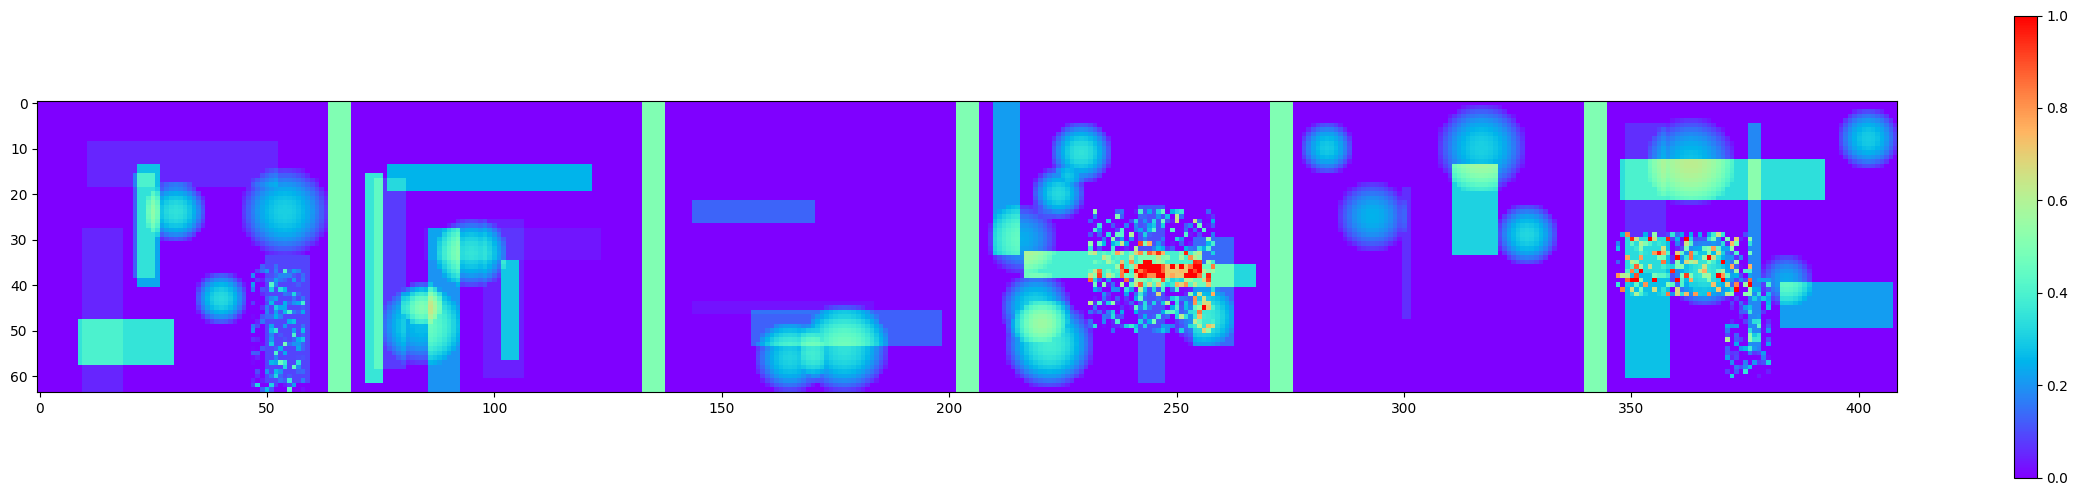

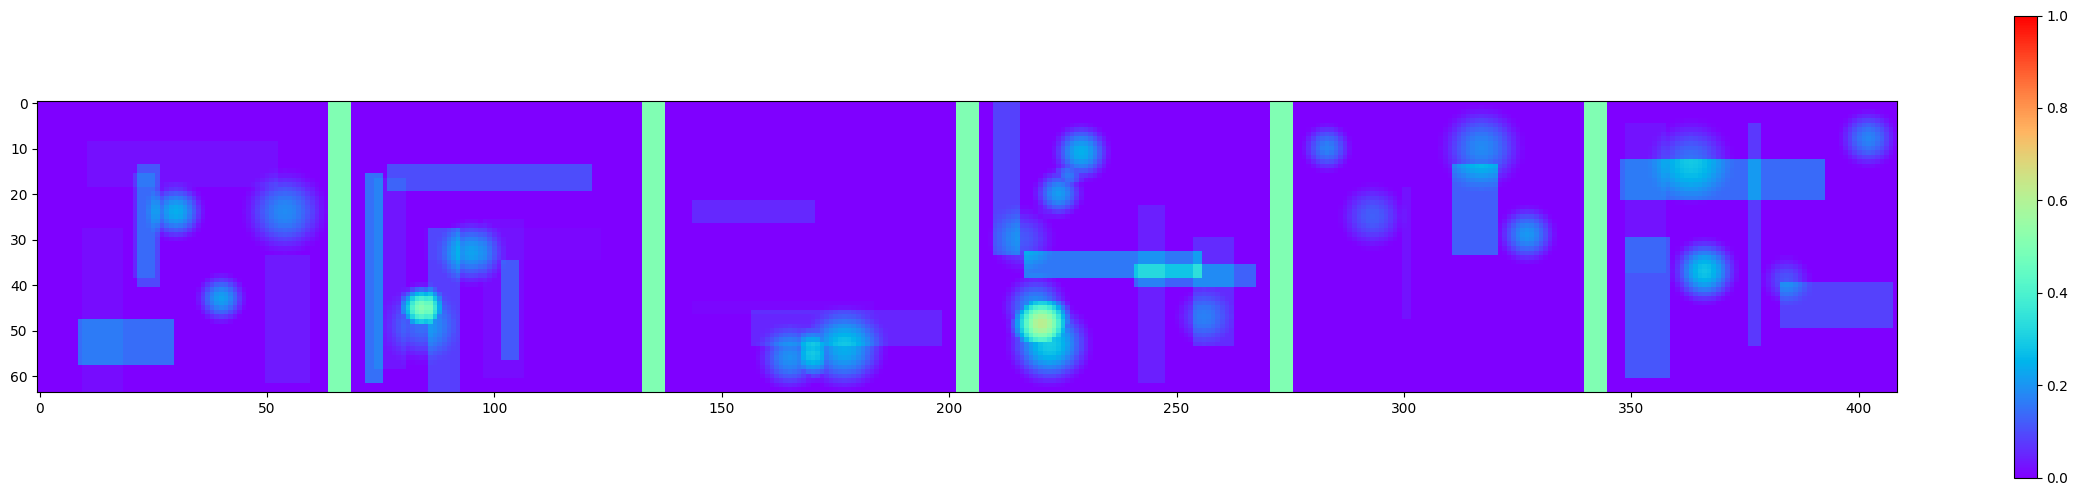

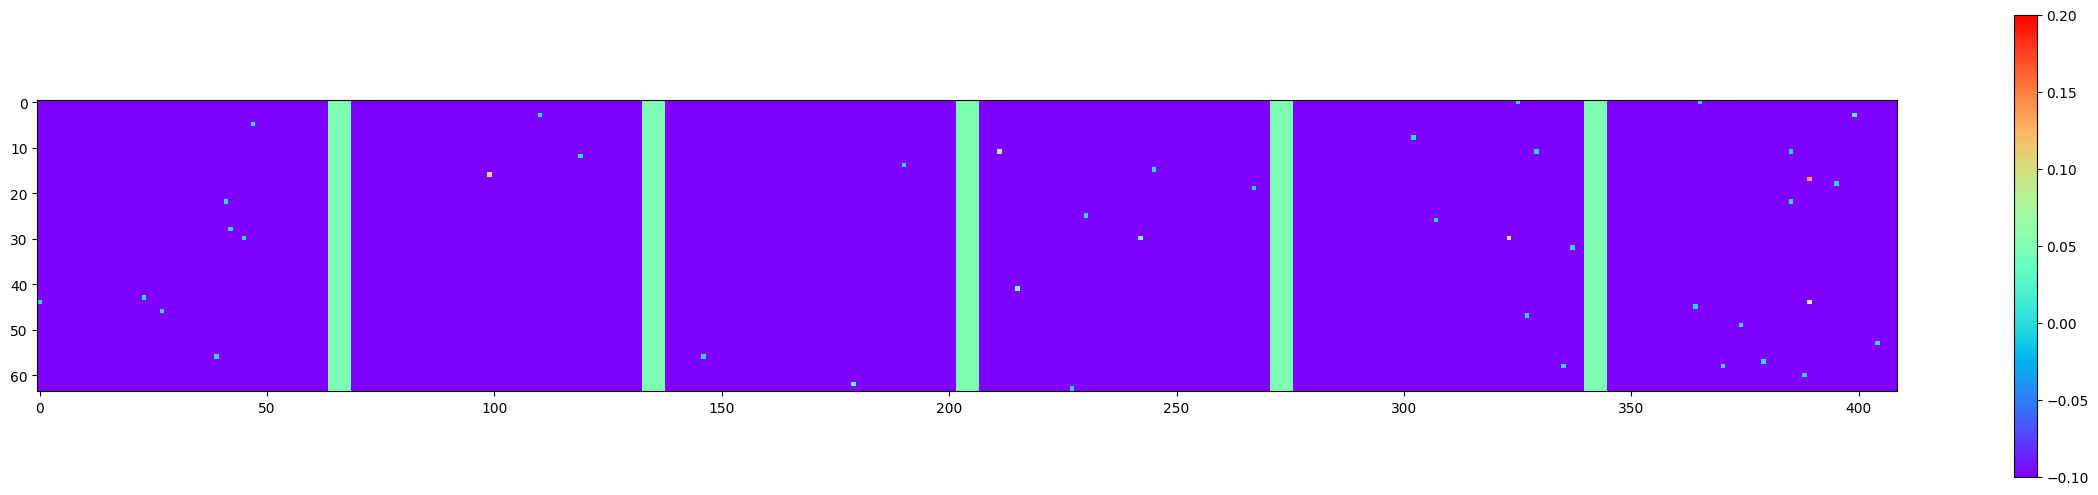

In [3]:
input,  target, fulltarget  = gen1(6,p=0.002)

# input: prédicteur spatialisé
fig0 = plt.figure(0, figsize=(30, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0, max_scale=1)

# fulltarget: cible complète, qu'on ne peut pas utiliser pour l'apprentissage
fig1 = plt.figure(1, figsize=(30, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0, max_scale=1)

# target: cible fragmentaire: (attention à l'échelle)
fig2 = plt.figure(2, figsize=(30, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1, max_scale=0.2)

**Q1** Pour entraîner un réseau de neurones sur une tâche de régression, on définit la fonction de coût *masked_MAE*.
Préciser le rôle du tenseur mask. Tester la fonction masked_MAE sur un batch généré par gen1.
       


In [4]:
def masked_MAE(output, target, mask):
  return (torch.abs(output-target))[mask].mean()

In [5]:
# test de la fonction masked_MAE :
input,  target, _  = gen1(6, p=0.002)

# prenons un output de la même dimension que l'entrée:
output = 0 * input + 1

# définissons le masque à partir de la cible fragmentaire:
# (le masque permet de limiter le calcul aux valeurs qui sont renseignées)
mask = target >= 0

# Calculons la loss:
loss = masked_MAE(output, target, mask)

print(loss)

tensor(0.9404)


**Q2** Pour cette tâche de régression, nous allons entraîner un UNet. Précisez les différentes couches contenues dans ce UNet, leur rôle et le nombre de poids total qu'il contient.

In [10]:
fcn = UNet(1,1,16)

# Suolution 1 :
params = list(fcn.parameters())
total_params = sum(p.numel() for p in params)
print(f"Nombre total de paramètres dans le modèle : {total_params}")


# Solution 2: issu du TP3 partie 1:
i=0
for module in fcn.modules():
    if isinstance(module, nn.Conv2d):
      i+=1

print(i)

pconv=0
pconvt=0
pbn=0
ptot=0

for module in fcn.modules():
    if isinstance(module, nn.Conv2d):
      for parameter in module.parameters():
        pconv += torch.numel(parameter) #numel: counts the number of elements in a matrix

    if isinstance(module, nn.ConvTranspose2d):
      for parameter in module.parameters():
        pconvt += torch.numel(parameter) #numel: counts the number of elements in a matrix

    if isinstance(module, nn.BatchNorm2d):
      for parameter in module.parameters():
        pbn += torch.numel(parameter)

print(pconv)  # number of weights in convolution layers
print(pconvt) #  " " in transpose convolution layers
print(pbn)    # number of weights in BatchNorm layers

print(pconv + pconvt + pbn)


Nombre total de paramètres dans le modèle : 926786
20
837522
87280
1984
926786


**Q3** Dans la fonction *run_train* coder une époque de l'entraînement du UNet précédent en exploitant la cible fragmentaire pour l'entraînement et la cible complète pour la validation. Rester sur CPU. **Commenter votre code**. \
On utilisera les hyperparamètres suivants :

In [ ]:
# optim: Adam, lr = 0.001
# batchs par époque: 50
# taille d'un batch: 64

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))
nbatches = 50
batchsize = 64
train_losses = []

def run_train(fcn, optimizer, p = 0.002):
  for i in range(nbatches):
      # génération d'un batch
      input, target, _ = gen1(batchsize, p)

      # mise à zéro des incréments
      optimizer.zero_grad()

      # inférence
      output = fcn(input)

      # calcul du masque
      mask = (target >= 0).detach()

      # calcul de la loss
      loss = masked_MAE(output, target, mask)

      # rétropropagation
      loss.backward()

      # application des incréments
      optimizer.step()

      # nettoyage
      del output, target, loss
      torch.cuda.empty_cache()

  return fcn, optimizer



In [ ]:
import time
t = time.time()
run_train(fcn, optimizer, p = 0.002)
print(time.time() - t)

50.53575611114502


**Q4** Dans la fonction *run_train_gpu*, passer sur GPU la phase d'entraînement sur GPU. Evaluer le speed-up.

In [ ]:
fcn = fcn.cuda()
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

def run_train_gpu(fcn, optimizer, p = 0.002):
  for i in range(nbatches):    # nbatch = datasetsize/batchsize

      input, target, _ = gen1(batchsize, p)
      input, target = input.cuda(), target.cuda()
      optimizer.zero_grad()
      output = fcn(input)
      mask = (target >= 0).detach()

      loss = masked_MAE(output, target, mask)
      loss.backward()
      optimizer.step()

      del output, target, loss
      torch.cuda.empty_cache()
  return fcn, optimizer

In [ ]:
# calcul du speed-up
import time
t = time.time()
run_train_gpu(fcn, optimizer, p = 0.002)
print(time.time() - t)

print('speed-up (ca) : ', 6)
#

**Q5** Pour calculer un score en validation, on se contentera de la MAE entre outputs et cibles complètes au sein de la phase d'entraînement. Rappeler le rôle de la validation, justifier le choix précédent et le coder dans la fonction *run_trainval_gpu()* suivante. Eviter tout calcul superflux.

In [ ]:
# L'étape de validation permet de contrôelr les performances en généralisation
# (et en particulier, de assurer qu'il n'y a pas de surapprentissage).
# Dans le cas général, le jeu de validation doit être indépendant du jeu d'entraînement.
# Dans notre cas particulier, chaque batch d'entraînement est original et n'a jamais été vu par le modèle.
# Il est donc possible de l'utiliser pour contrôler les perf. en généralisation.


def run_trainval_gpu(fcn, optimizer, p = 0.002):
  epoch_MAE_validations = []

  for i in range(nbatches):    # nbatch = datasetsize/batchsize

      input, target, complete_target = gen1(batchsize, p)
      input, target, complete_target = input.cuda(), target.cuda(), complete_target.cuda()

      optimizer.zero_grad()
      output = fcn(input)
      mask = (target >= 0).detach()

      loss = masked_MAE(output, target, mask)
      loss.backward()
      optimizer.step()

      # Pas de calcul superflux -> torch.no_grad()
      with torch.no_grad():
        batch_MAE_validation = torch.abs(output - complete_target).mean().cpu().item()
        # print(batch_MAE_validation)
        epoch_MAE_validations.append(batch_MAE_validation)


      del output, target, loss
      torch.cuda.empty_cache()

  epoch_MAE_validation = np.mean(epoch_MAE_validations)
  return fcn, optimizer, epoch_MAE_validation

In [ ]:
# test :
fcn, optimizer, MAE_validation = run_trainval_gpu(fcn, optimizer, p = 0.002)

0.02469399757683277
0.023754026740789413
0.02288462407886982
0.018692228943109512
0.019699212163686752
0.02081528678536415
0.020599013194441795
0.02079763449728489
0.01976199261844158
0.018484216183423996
0.023449741303920746
0.017556261271238327
0.02064642682671547
0.025444868952035904
0.021387865766882896
0.022638173773884773
0.02214249223470688
0.01873023435473442
0.018644185736775398
0.01853262260556221
0.018497131764888763
0.017640449106693268
0.016252614557743073
0.01712021976709366
0.01897738128900528
0.018196728080511093
0.0162510983645916
0.019908752292394638
0.0162457674741745
0.021460093557834625
0.017592644318938255
0.015464921481907368
0.017414089292287827
0.020501844584941864
0.0189250186085701
0.01752389967441559
0.01577230542898178
0.015314776450395584
0.02032225951552391
0.014341834001243114
0.02006707340478897
0.014350395649671555
0.021309927105903625
0.022514114156365395
0.02077654004096985
0.01758248545229435
0.016675736755132675
0.016539964824914932
0.0183264240622

**Q6** Générer deux versions du UNet précédent, initialisés de la même manière. Entraîner-les sur cinquante époques, chacun pour une valeur de *p* différente (0.01 et 0.001).
**Commenter votre code**. Tracer et discuter les courbes d'apprentissage.

In [ ]:
nepochs = 50
scores_1  = []
scores_2  = []

fcn = UNet(1,1,8).cuda()
# Même init:
fcn2 = UNet(1,1,8).cuda()
fcn2.load_state_dict(copy.deepcopy(fcn.state_dict))

optimizer = optim.Adam(fcn.parameters(), 10**(-3))
optimizer2 = optim.Adam(fcn2.parameters(), 10**(-3))

for epoch in range(nepochs):
    print("Epoch " + str(epoch))

    # epoch fcn:
    fcn, optimizer, MAE_validation_1 = run_trainval_gpu(fcn, optimizer, 0.01)
    fcn2, optimizer2, MAE_validation_2 = run_trainval_gpu(fcn2, optimizer2, 0.0001)

    scores_1.append(MAE_validation_1)
    scores_2.append(MAE_validation_2)

    print('MAE_validation_1:')
    print(str(MAE_validation_1))
    print('MAE_validation_2:')
    print(str(MAE_validation_2) + '\n')

Epoch 0
MAE_validation_1:
0.07953263491392136
MAE_validation_2:
0.09263071961700917

Epoch 1
MAE_validation_1:
0.025502839088439942
MAE_validation_2:
0.03197055328637362

Epoch 2
MAE_validation_1:
0.019860831145197152
MAE_validation_2:
0.02270975448191166

Epoch 3
MAE_validation_1:
0.016599108669906854
MAE_validation_2:
0.018885592557489873

Epoch 4
MAE_validation_1:
0.013384825438261033
MAE_validation_2:
0.016509376876056196

Epoch 5
MAE_validation_1:
0.012336591500788927
MAE_validation_2:
0.014793560523539782

Epoch 6
MAE_validation_1:
0.011231626123189927
MAE_validation_2:
0.01409549029543996

Epoch 7
MAE_validation_1:
0.010251621548086405
MAE_validation_2:
0.013613464441150427

Epoch 8
MAE_validation_1:
0.009971093516796828
MAE_validation_2:
0.013274783715605736

Epoch 9
MAE_validation_1:
0.009240241115912795
MAE_validation_2:
0.013045457359403372

Epoch 10
MAE_validation_1:
0.00899620714597404
MAE_validation_2:
0.012787415347993374

Epoch 11
MAE_validation_1:
0.008593780901283026


KeyboardInterrupt: 

**Q7** Visualiser les résultats des deux réseaux et commenter. Combien fallait-t-il d'époques supplémentaires au deuxième fcn pour rattraper le premier ?

[0.85859891 0.79769777 0.87455068 0.87892972 0.8107408  0.83391632
 0.79682408 0.75305016 0.75113039 0.70831101 0.70352037 0.73749233
 0.79089537 0.8173347  0.75367935 0.74182989 0.68796462 0.75072482
 0.68809791 0.72085539 0.72415352 0.68230346 0.74037902 0.73913838
 0.61613191 0.60756638 0.77866599 0.70936332 0.71564337 0.72700514
 0.67479876]
1.0
1.0
1.0
1.0
1.6
1.8333333333333333
2.0
2.875
2.888888888888889


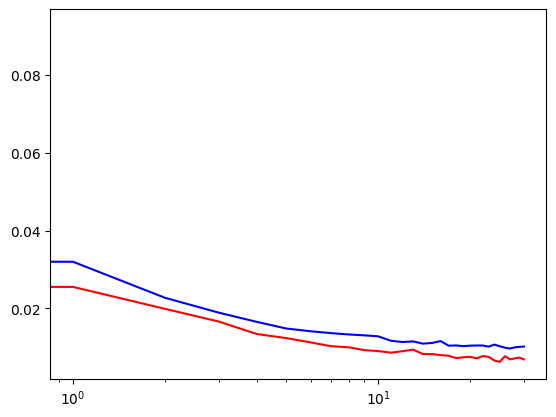

In [ ]:
plt.plot(scores_1, color='red')
plt.plot(scores_2, color='blue')
plt.xscale('log')

print(np.array(scores_1) / np.array(scores_2))
for i, s in enumerate(scores_1):
  try:
    print(np.where(np.array(scores_2) < s)[0][0]/(i+1))
  except:
    pass

# A la fin de cet apprentissage, il faut presque trois fois plus d'époques
# au deuxième réseau pour rattraper le premier.

**Partie II**\
Dans cette partie, nous supposons que la cible fragmentaire est disponible non seulement pendant l'apprentissage, mais aussi en phase de test.
Il devient donc possible de l'utiliser comme une entrée.

Avec la fonction *gen2*, cela va même s'avérer nécessaire : la cible fragmentaire contient une information essentielle à la prédiction de la cible complète.

En effet, le premier tenseur founi par *gen2* (ligne 1 ci-dessous) permet de dire où sont les pixels associés à des valeurs non nulles dans la cible complète (ligne 2).
Par contre, ce premier tenseur ne suffit pas à préciser l'intensité du signal cible : pour certaines cellules (premier type de cellules, en rouge sur la troisième ligne) le signal cible est plus fort que sur le premier tenseur, alors que pour d'autres cellules (deuxième type de cellule, en cyan), il est plus faible. Et rien dans le premier tenseur n'indique à quel type de cellule on a affaire.

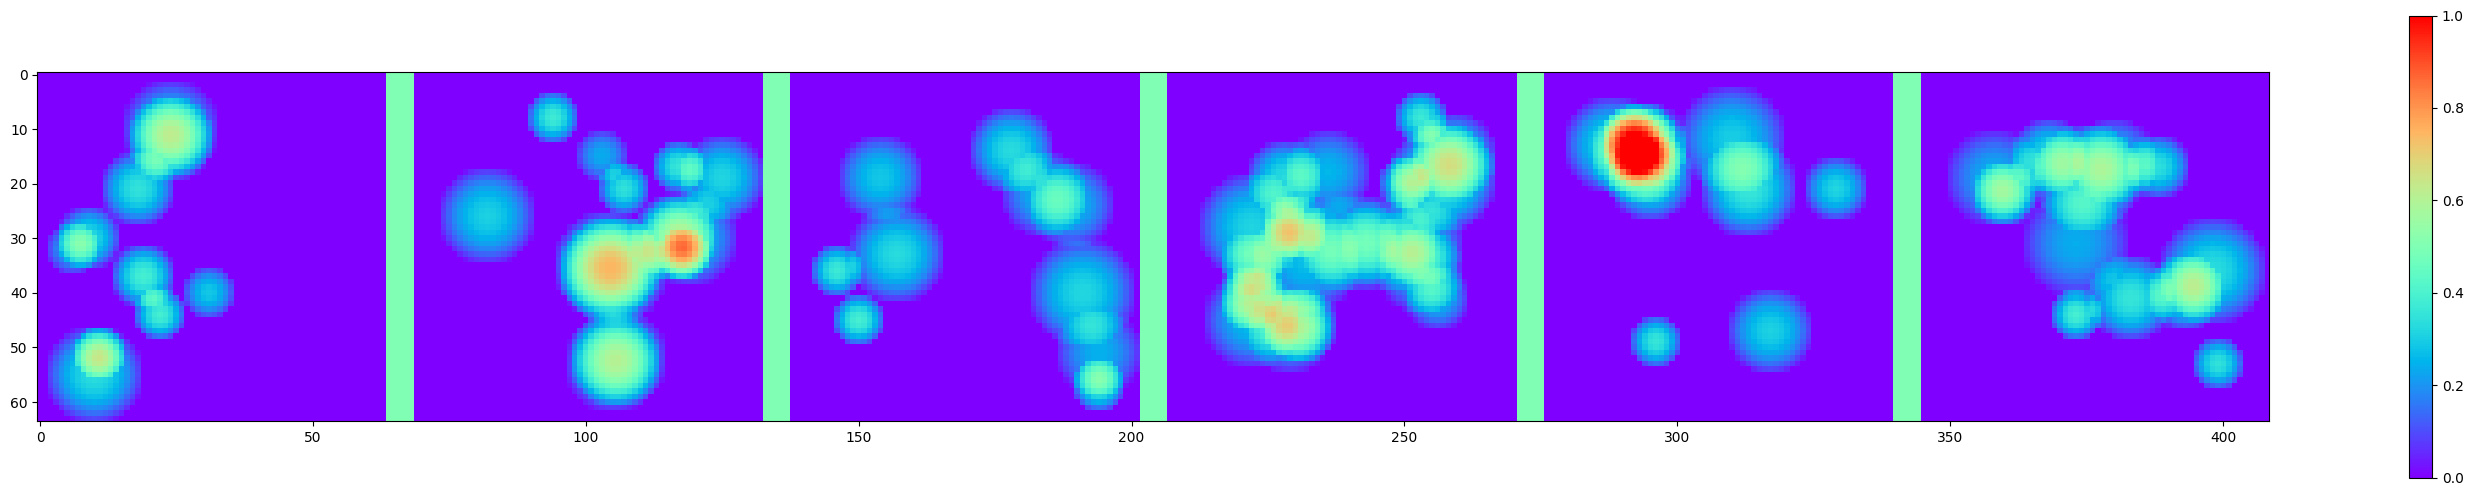

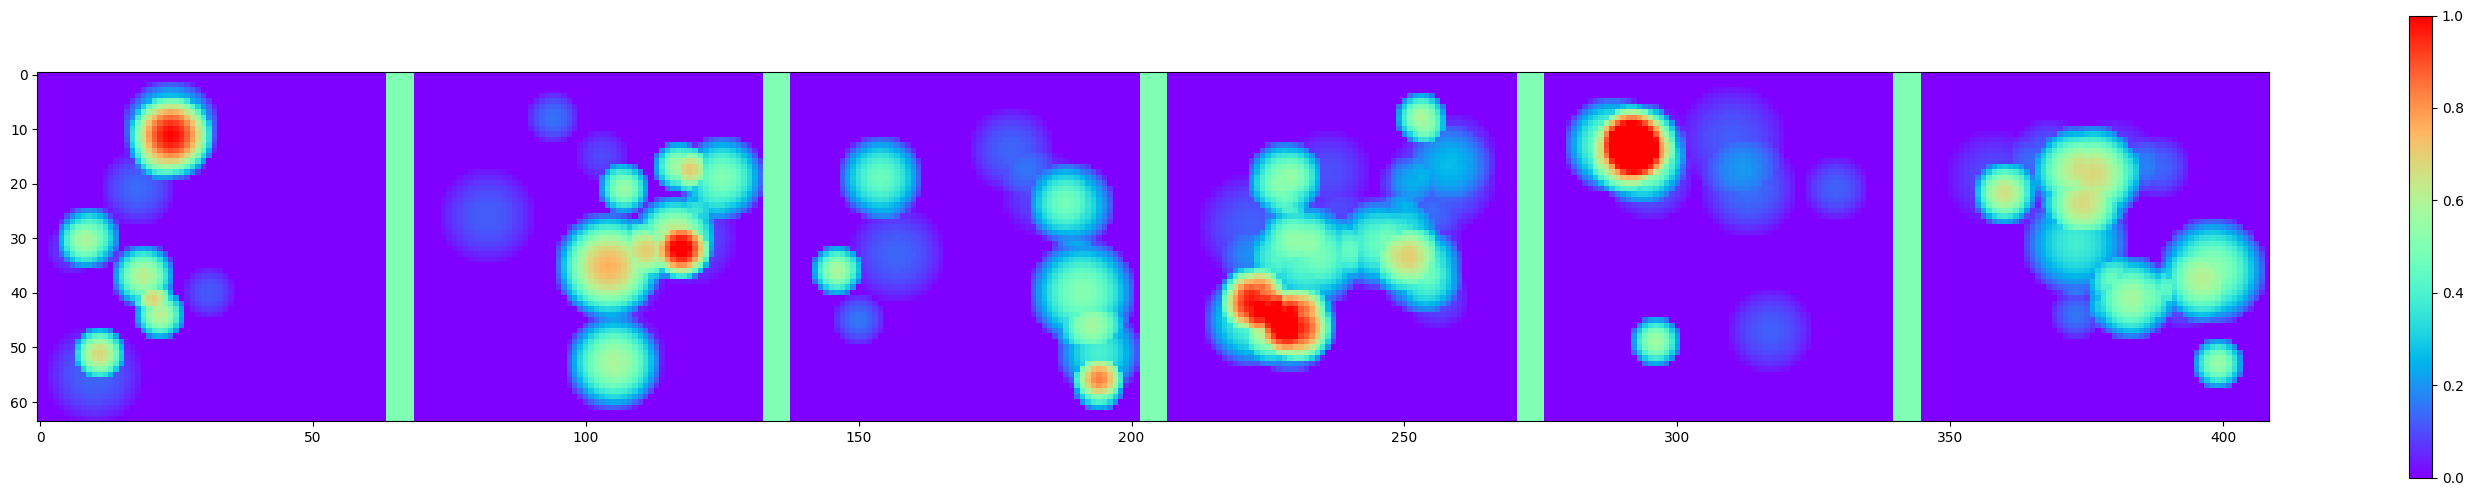

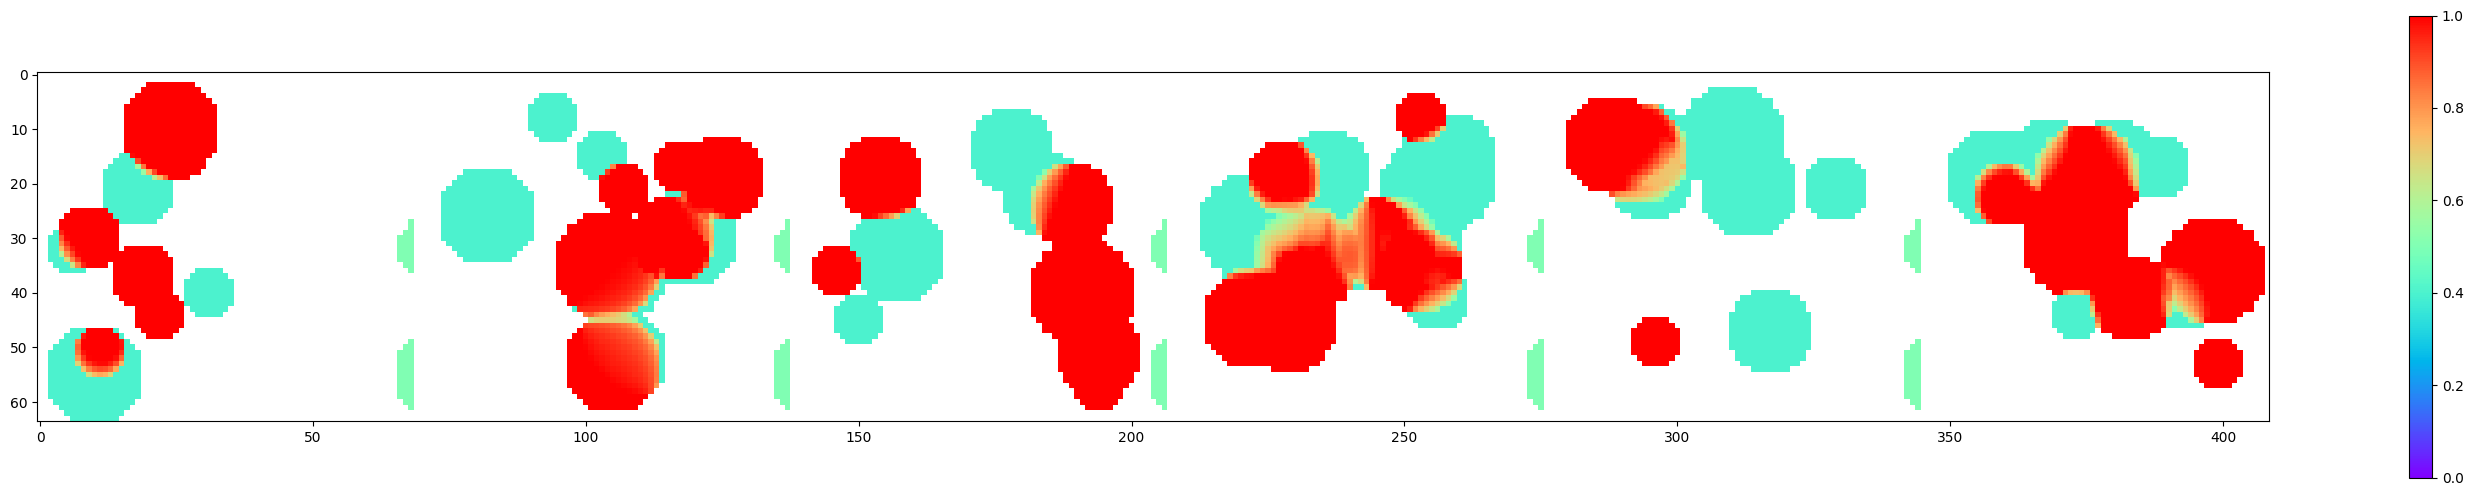

In [ ]:
input, target, fulltarget  = gen2(6,0.01)

# le signal d'entrée, spatialisé
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# le signal cible complet où les deux types de cellules apparaissent
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0,max_scale=1)

# le rapport entre les deux
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((fulltarget/input), 6, fig1, k=0, min_scale=0,max_scale=1)

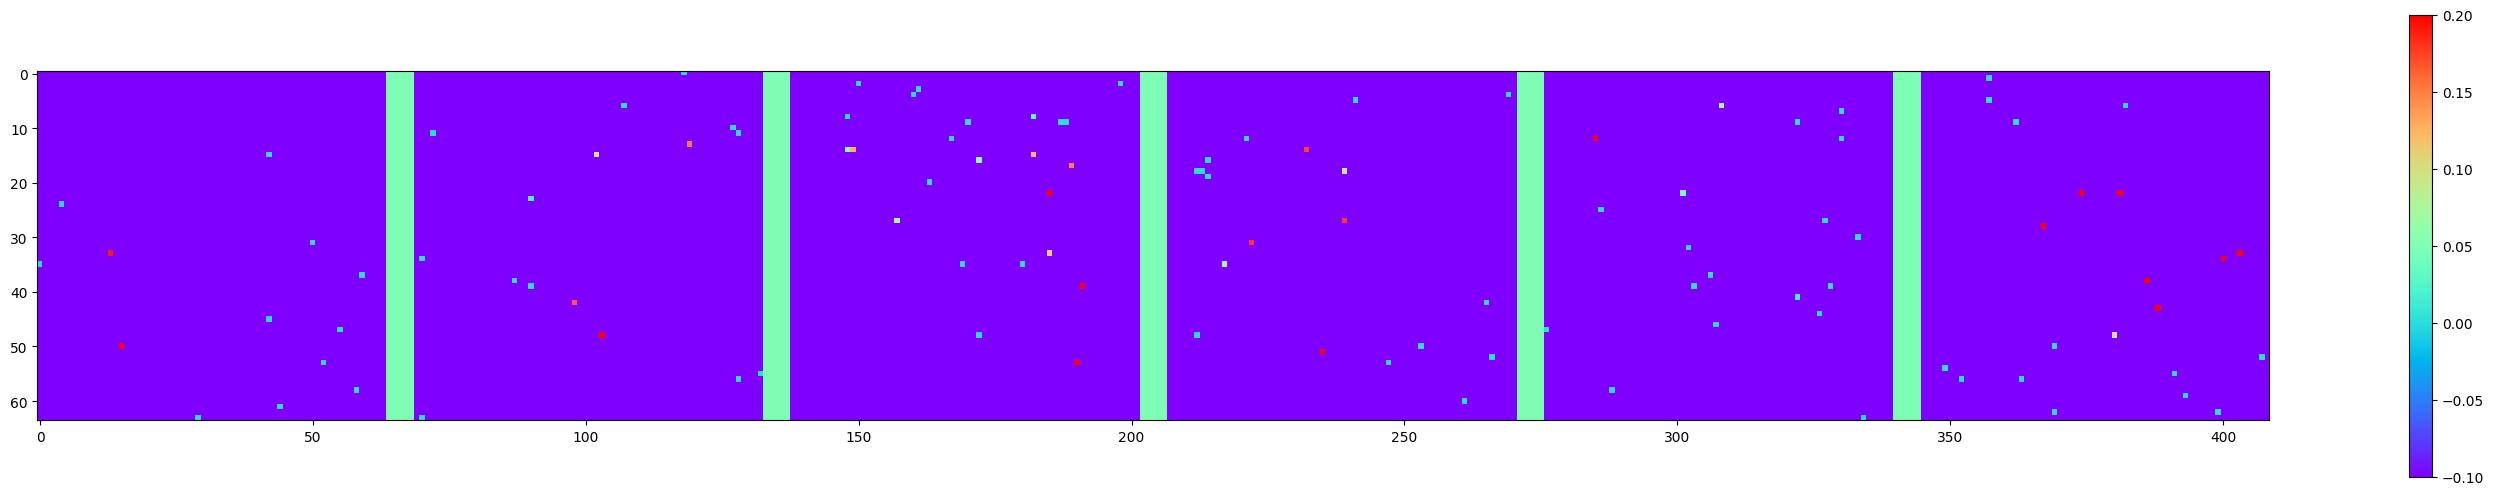

In [ ]:
#la cible fragmentaire:
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1,max_scale=0.2)

La cible fragmentaire ne comporte, là encore, qu'une faible proportion des valeurs du champ cible. Mais ces quelques valeurs contiennent, elles, une information sur le type de cellule. Il va donc s'agir d'entraîner le réseau à exploiter cette information supplémentaire.


**NB:** De même que dans la partie I, dans la cible fragmentaire les valeurs manquantes sont codées par -1 et toutes les autres valeurs sont positives ou nulles.

**Q1** Dans un premier temps, entraîner un UNet sur la cible fragmentaire **en n'utilisant que le prédicteur en entrée**. Les autres consignes sont :
- Choisir la fonction de coût de manière à estimer la moyenne conditionnelle à l'entrée.
- Pour la phase de validation, évaluer l'écart entre la cible complète et les outputs de la phase d'entraînement (voir partie I).
- Stocker la liste des scores en validation.
- Utiliser les hyperparamètres ci-dessous:

In [ ]:
import torch.optim as optim
fcn = UNet(1,1,8).cuda()
optimizer = optim.Adam(fcn.parameters(), 10**(-3))
nepochs = 10
nbatches = 100
batchsize = 64
p = 0.01

In [ ]:
def masked_MSE(output, target, mask):
  return (((output-target)[mask])**2).mean()

In [ ]:
def run_trainval_gpu(fcn, optimizer, p = 0.01):
  epoch_MSE_validations = []

  for i in range(nbatches):    # nbatch = datasetsize/batchsize

      input, target, complete_target = gen2(batchsize, p)
      input, target, complete_target = input.cuda(), target.cuda(), complete_target.cuda()

      optimizer.zero_grad()
      output = fcn(input)
      mask = (target >= 0).detach()

      loss = masked_MSE(output, target, mask)
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        batch_MSE_validation = ((output - complete_target)**2).mean().cpu().item()
        epoch_MSE_validations.append(batch_MSE_validation)


      del output, target, loss
      torch.cuda.empty_cache()

  epoch_MSE_validation = np.mean(epoch_MSE_validations)
  return fcn, optimizer, epoch_MSE_validation

In [ ]:
scores_1  = []

fcn = UNet(1,1,16).cuda()

optimizer = optim.Adam(fcn.parameters(), 10**(-3))

for epoch in range(nepochs):
    print("Epoch " + str(epoch))

    # epoch fcn:
    fcn, optimizer, MSE_validation_1 = run_trainval_gpu(fcn, optimizer, 0.01)
    scores_1.append(MSE_validation_1)

    print('MSE_validation_1:')
    print(str(MSE_validation_1))

Epoch 0
MSE_validation_1:
0.012981688887812197
Epoch 1
MSE_validation_1:
0.0053078942792490124
Epoch 2
MSE_validation_1:
0.0051729547791183
Epoch 3
MSE_validation_1:
0.005066387243568897
Epoch 4
MSE_validation_1:
0.004992626612074673
Epoch 5
MSE_validation_1:
0.004976398590952158
Epoch 6
MSE_validation_1:
0.004930303106084466
Epoch 7
MSE_validation_1:
0.004938574139960111
Epoch 8
MSE_validation_1:
0.004903238671831786
Epoch 9
MSE_validation_1:
0.0049096341989934445


**Q2** Pourquoi les performances stagnent-elles ? Visualiser quelques outputs et vérifier que le réseau restitue simplement le champ d'entrée. Expliquer pourquoi.

In [ ]:
fcn.eval()
input,  target, fulltarget  = gen2(6, p)

fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)  #première ligne de figures: les entrées

fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0,max_scale=1)  #deuxième ligne: les cibles

fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.5,max_scale=1)  #troisième ligne la cible fragmentaire

output = fcn(input.cuda()).detach().cpu()

fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(output, 6, fig3, k=0, min_scale=0,max_scale=1) #quatrième ligne: les sorties

# Tant que l'info sur la nature de la cellule n'est pas connu,
# le score ne peut pas augmenter.
# le modèle se contante de moyenner les deux cas: renforcement ou atténuation de la cellule.
# On constate facilement qu'en moyenne, renorcement et atténuation se compensent.
# Pour cette raison, le réseau restitue le champ d'entrée.

On se place maintenant dans le cas où les observations ponctuelles (cible fragmentaire) sont aussi disponibles comme prédicteur.

**Q3** Une idée simple consiste à définir un deuxième tenseur d'entrée ne comptant qu'une valeur de la cible fragmentaire sur deux. Les autres valeurs de la cible fragmentaire sont utilisées comme cible.
Mettre en oeuvre cette idée.

**Remarques:**
- La fonction *torch.bernoulli* permet de masquer environ 50% des valeurs d'un tenseur...
- Attention à la mutabilité des tenseurs pytorch.

In [ ]:
import copy

def run_trainval_gpu2(fcn, optimizer, p = 0.002):
  epoch_MSE_validations = []

  for i in range(nbatches):    # nbatch = datasetsize/batchsize

      input, target, complete_target = gen2(batchsize, p)
      input, target, complete_target = input.cuda(), target.cuda(), complete_target.cuda()

      # Une idée simple est de sélectionner la moitié des cibles pour en faire des entrées
      newmask = torch.bernoulli(0*target + 0.5)
      input2 = copy.deepcopy(target) #mesures ponctuelles utilisées en entrée
      input2[newmask==1] = -1
      target[newmask==0] = -1  #mesures ponctuelles utilisées comme cible
      newinput = torch.cat((input, input2), dim = 1)  #mesure spatialisée + mesures poncutelles

      optimizer.zero_grad()
      output = fcn(newinput)
      mask = (target >= 0).detach()

      loss = masked_MSE(output, target, mask)
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        batch_MSE_validation = ((output - complete_target)**2).mean().cpu().item()
        epoch_MSE_validations.append(batch_MSE_validation)


      del output, target, loss
      torch.cuda.empty_cache()

  epoch_MSE_validation = np.mean(epoch_MSE_validations)
  return fcn, optimizer, epoch_MSE_validation

**Q3** Entraîner ce réseau sur dix époques, comparer la courbe d'apprentissage obtenue avec la précédente et expliquer.

In [ ]:
nepochs = 15
fcn = UNet(2,1,16).cuda()
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [ ]:
scores_2  = []

fcn = UNet(2,1,32).cuda()
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

for epoch in range(nepochs):
    print("Epoch " + str(epoch))

    # epoch fcn:
    fcn, optimizer, MSE_validation_2 = run_trainval_gpu2(fcn, optimizer, p)
    scores_2.append(MSE_validation_2)

    print('MSE_validation_2:')
    print(str(MSE_validation_2))

In [ ]:
plt.plot(scores_1, color='red')
plt.plot(scores_2, color='blue')

**Q4** Visualiser des batches d'outputs. Dans quelle mesure le réseau parvient-il à lever l'ambiguïté sur le type de cellule en présence ?

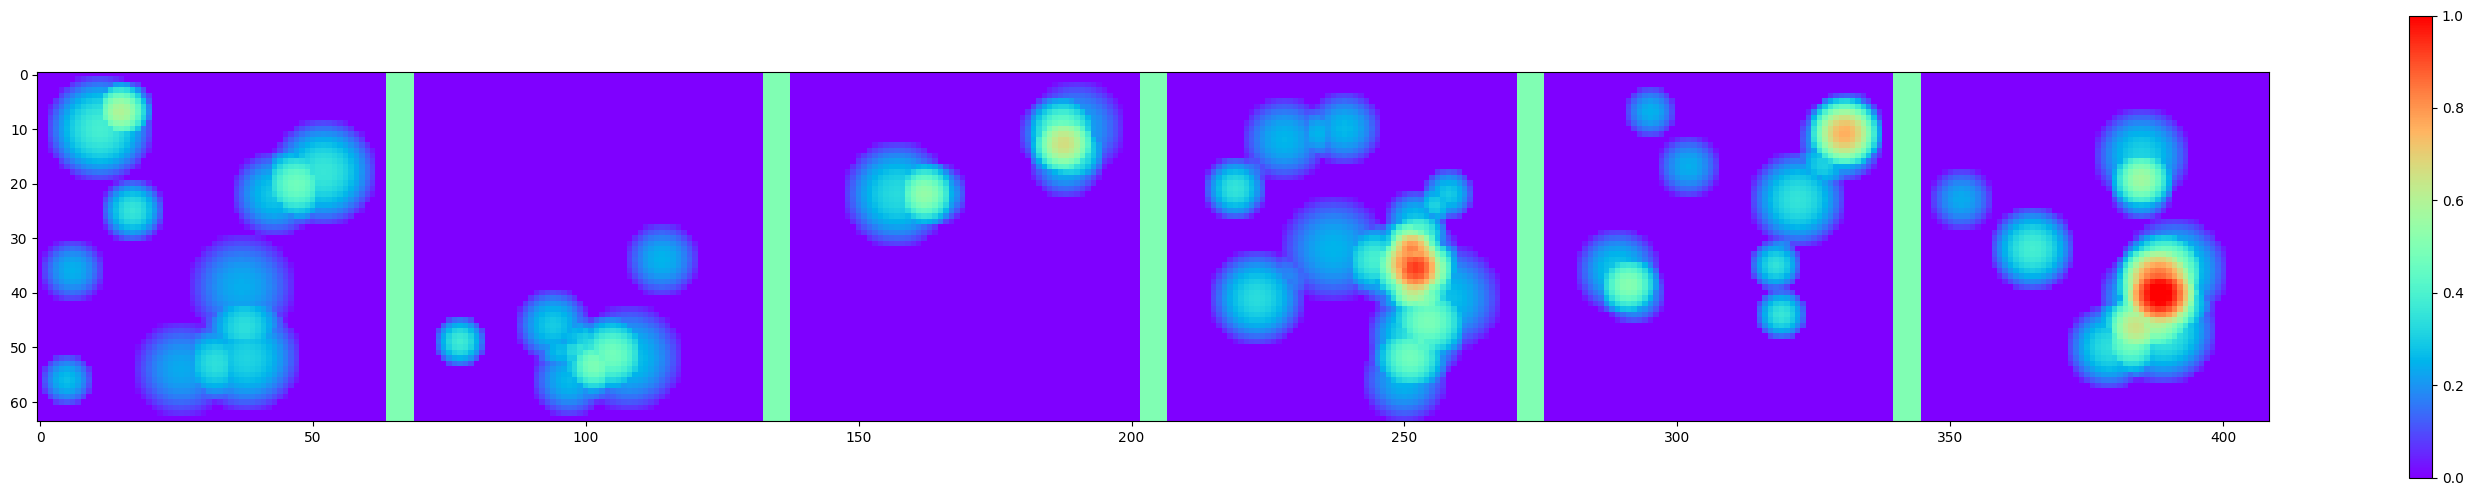

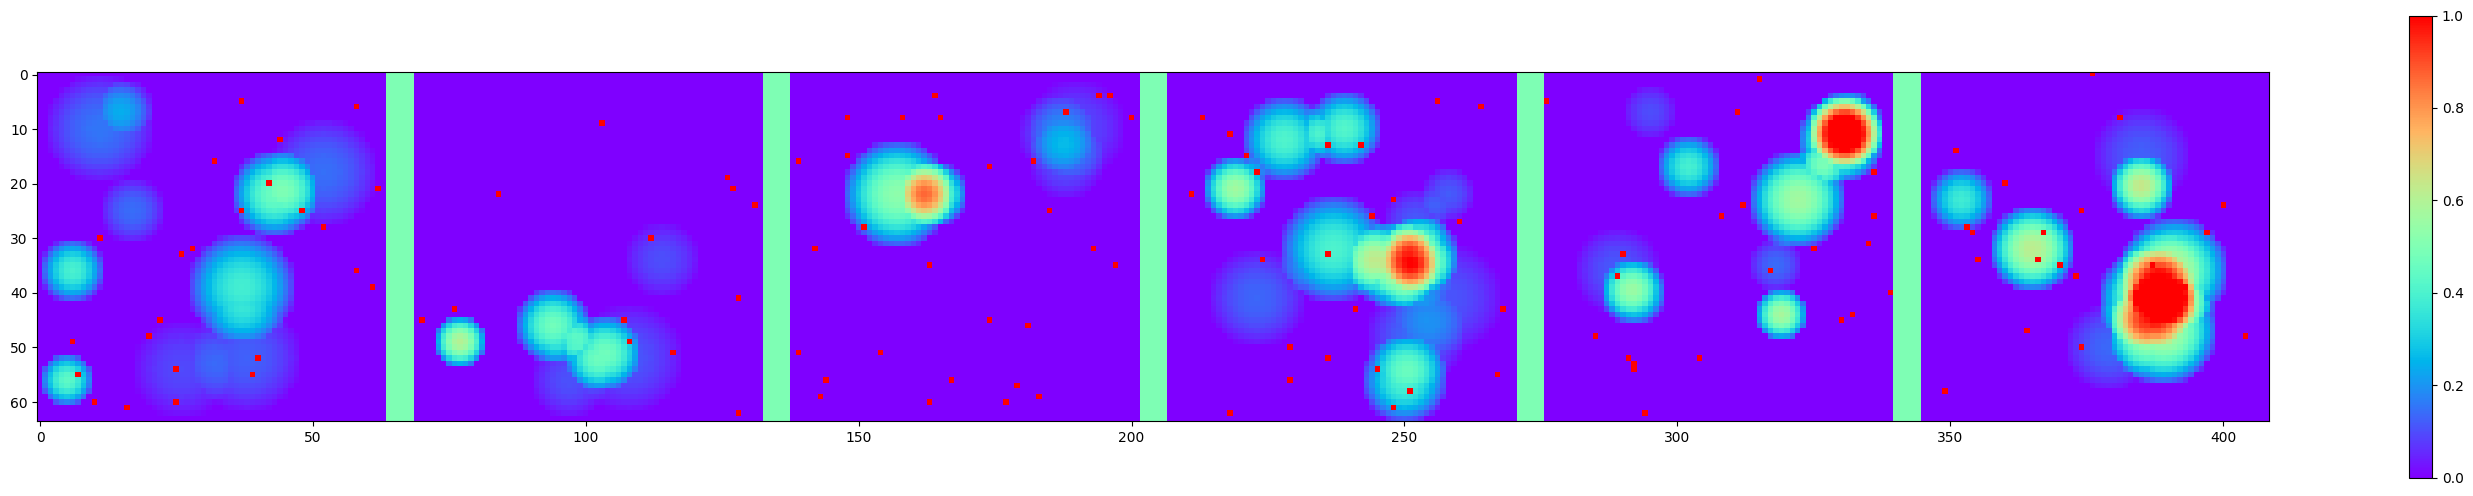

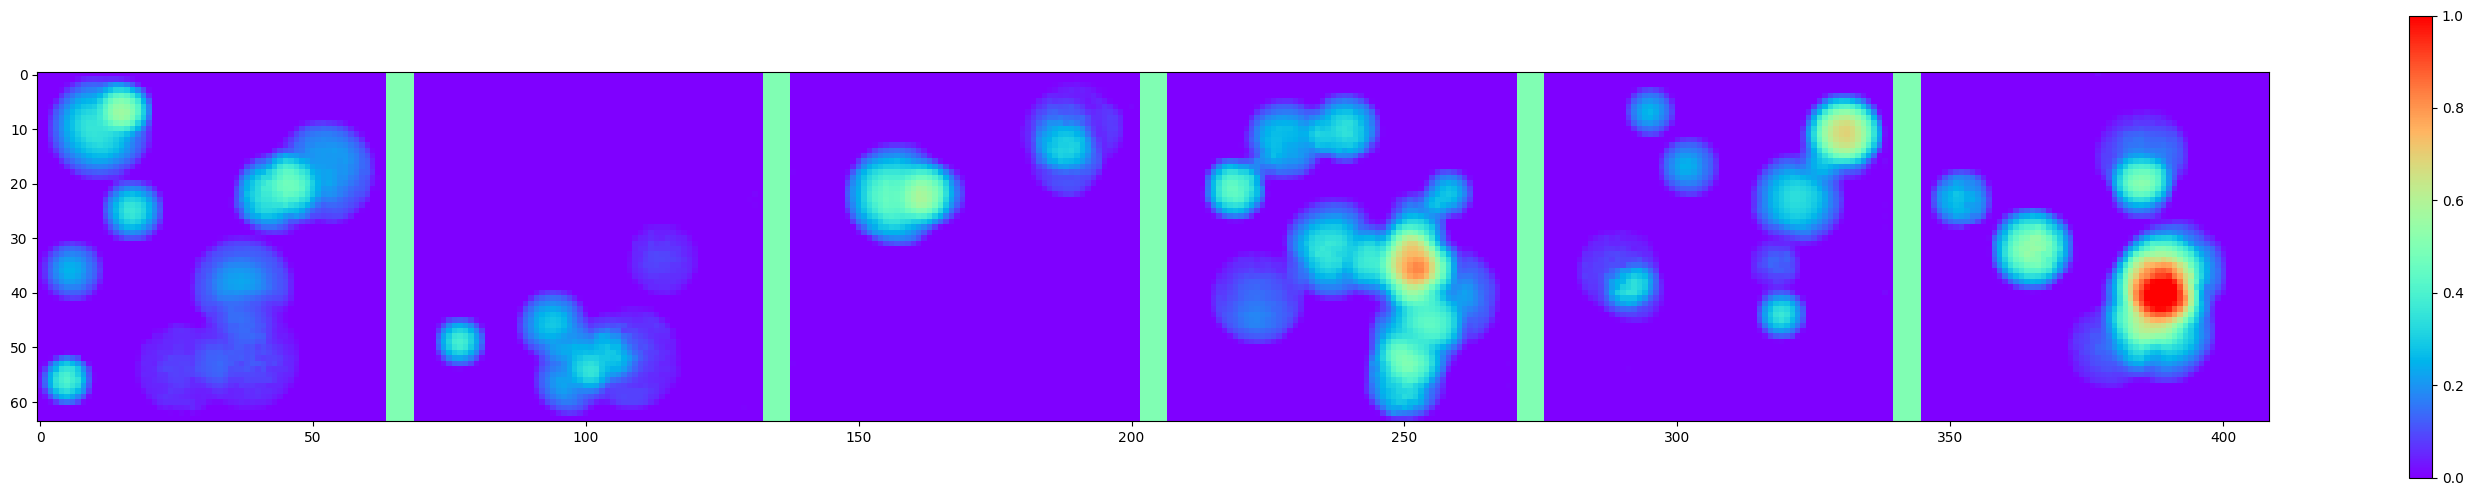

In [ ]:
fcn.eval()
input,  target, fulltarget  = gen2(6, p = 0.005)

fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)  #première ligne de figures: les entrées

fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((target>=0) + fulltarget, 6, fig1, k=0, min_scale=0.,max_scale=1)  #troisième ligne la cible fragmentaire

output = fcn(torch.cat((input,target),dim=1).cuda()).detach().cpu()

fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output, 6, fig2, k=0, min_scale=0,max_scale=1) #quatrième ligne: les sorties

**Q6** Au cours d'un apprentissage, nous avons utilisé (environ) la moitié de la cible fragmentaire à disposition. Quel peut être le défaut de cette approche ? Jouer sur la valeur de *p* pour pouvoir l'illustrer.

In [ ]:
# Pour des valeurs de p différentes, les performances semblent moins bonnes.
# C'est un problème courant: dès que les stat des entrées changent
# le réseau peut éprouver des difficultés.
# Ainsi, avec beaucoup plus de points à intégrer, le réseau de neurones
# se paradoxalement plus mal qu'avec peu de point. C'est
# un problème connu sous le nom de "domain gap" ou "domain shift".
# Pour l'atténuer, une approche consisterait à faire varier la proportion
# de points utilisés en entrée.

**Q7** Pour prédire la valeur d'un pixel, un FCN permet de prendre en compte le contexte, c'est à dire l'information contenue dans un large voisinage autour du pixel d'intérêt.\
Cette qualité était-elle nécessaire pour traiter la **partie I** du problème ? Etait-elle nécessaire pour traiter la **partie II** ? Justifier.

In [ ]:
# Elle était nécessaire dans les deux parties:
# il fallait nécessairement distinguer les disques des rectangles dans la première partie
# pour pouvoir restituer le champ cible. Cette distinction ne peut
# se faire qu'en tenant compte du contexte.
# Dans la seconde partie, il fallait pouvoir étendre l'influence d'une mesure
# ponctuelle sous tout le disque concerné. Pour le faire, il faut nécessairement
# pouvoir "voir" le signal comme une superpositions de disques et là encore,
# la prise en compte du contexte est indispensable.